# Poisson equation in a multi-patch domain

In [6]:
%matplotlib inline

import numpy as np
import scipy
import matplotlib.pyplot as plt
import itertools

np.set_printoptions(linewidth=100000)

from pyiga import bspline, assemble, vform, geometry, vis, solvers, topology, adaptive
from pyiga import assemble_cy

In [7]:
# define discretization space (we may choose nested discretization spaces)
p = 3
N = 10
kvs = [2 * (bspline.make_knots(p, 0.0, 1.0, N),),
       2 * (bspline.make_knots(p, 0.0, 1.0, N),),
       2 * (bspline.make_knots(p, 0.0, 1.0, N),),
       2 * (bspline.make_knots(p, 0.0, 1.0, N),)]

In [8]:
# define geometry
geos = [
    geometry.quarter_annulus(),
    geometry.unit_square().translate((-1, 1)),
    geometry.quarter_annulus().rotate_2d(np.pi).translate((-1, 3)),
    geometry.quarter_annulus().rotate_2d(-np.pi/2).translate((-2, 1))
]

patches = [(kv, g) for kv,g in zip(kvs,geos)]

In [9]:
# source term f and Dirichlet boundary function g
f  = lambda x, y: np.exp(-5 * ((x-0.3)**2 + (y-1)**2))
gD = lambda x, y: 1e-1 * np.sin(8*x)

# Robin boundary data such that \partial_n u + alpha * u = g1, if alpha=0 this represents also a Neumann boundary condition.
gN = lambda x, y: 0.
alpha = lambda x, y: 0.

# set up a PatchMesh object, which detects interfaces between patches
M = topology.PatchMesh(patches)

# by default all outer boundaries are given the index 0, which we will use for the Dirichlet boundary
# let us generate a Neumann boundary indexed by 1
M.set_boundary_id({'Neumann/Robin':{(0,'left'),(2,'right'),(3,'left'),(3,'right')},
                   'Dirichlet':{(0,'bottom'),(0,'right'),(1,'top'),(2,'bottom'),(2,'left'),(3,'bottom')}})

# set up a MultiPatch object that initializes a Basis to map global dofs to local dofs
MP = assemble.Multipatch(M, automatch=True)

# set Dirichlet values for DoFs at the Dirichlet boundary
dir_bcs = MP.set_dirichlet_boundary({'Dirichlet':gD})

# assemble the linear system and (possible) Neumann vector or Robin matrix/vector
Kh = MP.assemble_volume("inner(grad(u), grad(v)) * dx", arity = 2)
Fh = MP.assemble_volume("f * v * dx", arity=1, physical=True, f=f) #f is living in the physical domain

# generate Neumann vector for global contribution to the right hand side, in this case it is a zero vector since g1 is zero
Nh = MP.assemble_surface('(gN * v) * ds', arity=1, gN=gN, boundary_idx='Neumann/Robin')

# generate Robin Matrix for global contribution to the right hand side, in this case it is a zero matrix again since alpha is zero
Rh = MP.assemble_surface('(alpha * u * v) * ds', arity=2, alpha=alpha, boundary_idx='Neumann/Robin')

setting up constraints took 0.0058574676513671875 seconds.
Basis setup took 0.0021278858184814453 seconds


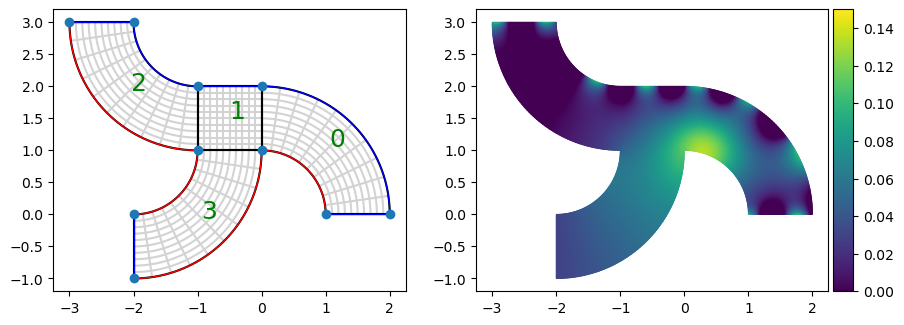

In [10]:
# set up and solve linear system by eliminating Dirichlet DoFs from the system
LS = assemble.RestrictedLinearSystem(Kh + Rh, Fh + Nh, dir_bcs)
u = LS.complete(solvers.make_solver(LS.A, spd=True)@LS.b)

# restrict solution to each individual patch (kvs on every patch) and visualize solution together with the mesh
fig, ax = plt.subplots(1,2,figsize=(10,5))
M.plotmesh(patch_idx = True, knots=True, nodes=True, bcolor={'Dirichlet':'blue','Neumann/Robin':'red'}, axis=ax[0])
MP.plot(u, range = (0, 1.5e-1),cbar=True, cmap='viridis', axis=ax[1], aspect='equal', cbar_width=0.2, cbar_pad = 0.05);
ax[0].axis('scaled'); #ax[1].axis('scaled');

# Computerchip

In [11]:
# define geometry
def ComputerChip(p, N):
    geos = [
        geometry.Quad(np.array([[0,0.5,0.35, 0.5],[0,0,0.3,0.15]])),
        geometry.Quad(np.array([[0, 0.35, 0, 0.17],[0, 0.3, 0.6, 0.6]])),
        geometry.Quad(np.array([[0.35, 0.5, 0.17, 0.5],[0.3, 0.45, 0.6, 0.6]])),
        geometry.Quad(np.array([[0.17, 0.5, 0.17, 0.5],[0.6, 0.6, 0.8, 0.8]])),
        geometry.Quad(np.array([[0.5,1,0.5, 0.65],[0,0,0.15,0.3]])),
        geometry.Quad(np.array([[0.65, 1, 0.83, 1],[0.3,0,0.6,0.6]])),
        geometry.Quad(np.array([[0.5,0.65,0.5,0.83],[0.45,0.3,0.6,0.6]])),
        geometry.Quad(np.array([[0.5, 0.83, 0.5, 0.83],[0.6, 0.6, 0.8, 0.8]])),
    ]

    kvs = 8 * [2 * (bspline.make_knots(p, 0.0, 1.0, N),)]
    
    patches = [(kv, g) for kv,g in zip(kvs,geos)]
    M = topology.PatchMesh(patches)
    
    M.set_boundary_id({'Dirichlet':{(0,'top'),(2,'bottom'),(4,'top'),(6,'bottom')},
                       'Neumann':{(1,'top'),(1,'left'),(3,'top'),(3,'left'),(5,'top'),(5,'right'),(7,'top'),(7,'right')},
                       'Robin' : {(0,'bottom'),(4,'bottom')}})
    M.set_domain_id({0:{0,1,2,4,5,6}, 1:{3,7}})
    return M

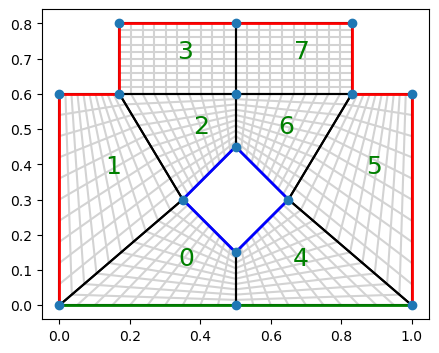

In [12]:
M = ComputerChip(3,10)

# visualize the PatchMesh object with Dirichlet boundary (blue) and Neumann boundary (red)
M.plotmesh(patch_idx = True, knots=True, nodes=True, bcolor={'Dirichlet':'blue','Neumann':'red','Robin':'green'}, bwidth=2)
plt.axis('scaled');

In [13]:
kappa = 130.0
alpha = 0.2
f = lambda x,y: 0.0
gN = lambda x,y: 0.0
gD = lambda x,y: 500.0
gR = lambda x,y: 300.0*alpha
lambda0 = 0.01
lambda1 = 3.95

In [14]:
MP = assemble.Multipatch(M, automatch=True)

# set Dirichlet values for DoFs at the Dirichlet boundary
dir_bcs = MP.set_dirichlet_boundary({'Dirichlet':gD})

# assemble the linear system and (possible) Neumann vector or Robin matrix/vector
Kh = MP.assemble_volume("lambda0 * inner(grad(u), grad(v)) * dx", arity = 2, domain_id=0, lambda0=lambda0) + MP.assemble_volume("lambda1 * inner(grad(u), grad(v)) * dx", arity = 2, domain_id=1, lambda1=lambda1)
Fh = MP.assemble_volume("f * v * dx", arity=1, f=f) #f is living in the physical domain

# generate Neumann vector for global contribution to the right hand side, in this case it is a zero vector since g1 is zero
Nh = MP.assemble_surface('(gN * v) * ds', arity=1, gN=gN, boundary_idx='Neumann')

# generate Robin Matrix for global contribution to the right hand side, in this case it is a zero matrix again since alpha is zero
Rh = MP.assemble_surface('(alpha * u * v) * ds', arity=2, alpha=alpha, boundary_idx='Robin')
Nh += MP.assemble_surface('(gR * v) * ds', arity=1, gR=gR, boundary_idx='Robin')

setting up constraints took 0.03619575500488281 seconds.
Basis setup took 0.0061321258544921875 seconds


In [15]:
LS = assemble.RestrictedLinearSystem(Kh + Rh, Fh + Nh, dir_bcs)
u = LS.complete(solvers.make_solver(LS.A, spd=True)@LS.b)

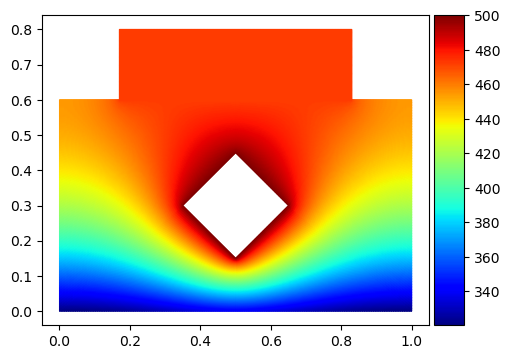

In [16]:
MP.plot(u, cbar=True, cmap='jet', aspect='equal', figsize=(5,5), physical=True);

# Using non-matching multi-patch domains for adaptive refinement

In [23]:
def solveChip(MP):
    kappa = 130.0
    alpha = 0.2
    f = lambda x,y: 0.0
    gN = lambda x,y: 0.0
    gD = lambda x,y: 500.0
    gR = lambda x,y: 300.0*alpha
    lambda0 = 0.01
    lambda1 = 3.95

    Kh = MP.assemble_volume("lambda0 * inner(grad(u), grad(v)) * dx", arity = 2, domain_id=0, lambda0=lambda0) + MP.assemble_volume("lambda1 * inner(grad(u), grad(v)) * dx", arity = 2, domain_id=1, lambda1=lambda1)
    Fh = MP.assemble_volume("f * v * dx", arity=1, f=f) #f is living in the physical domain

    Nh = MP.assemble_surface('(gN * v) * ds', arity=1, gN=gN, boundary_idx='Neumann')
    Rh = MP.assemble_surface('(alpha * u * v) * ds', arity=2, alpha=alpha, boundary_idx='Robin')
    Nh += MP.assemble_surface('(gR * v) * ds', arity=1, gR=gR, boundary_idx='Robin')

    LS = assemble.RestrictedLinearSystem(Kh + Rh, Fh + Nh, dir_bcs)
    return LS.complete(solvers.make_solver(LS.A, spd=True)@LS.b)

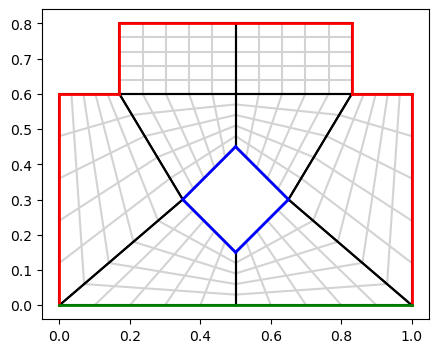

setting up constraints took 0.012411117553710938 seconds.
Basis setup took 0.0024416446685791016 seconds
Residual contributions took 0.0581 seconds.
Jump contributions took 0.0441 seconds.


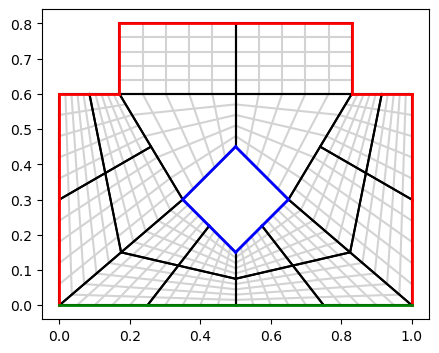

setting up constraints took 0.03923654556274414 seconds.
Basis setup took 0.002561807632446289 seconds
Residual contributions took 0.146 seconds.
Jump contributions took 0.162 seconds.


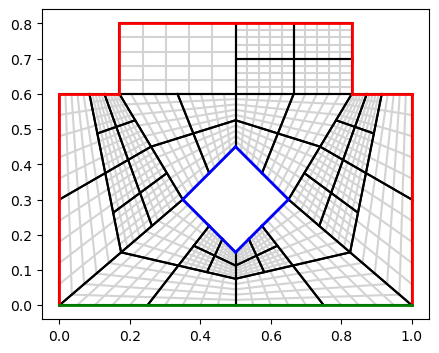

setting up constraints took 0.6117005348205566 seconds.
Basis setup took 0.003637552261352539 seconds
Residual contributions took 0.296 seconds.
Jump contributions took 0.462 seconds.


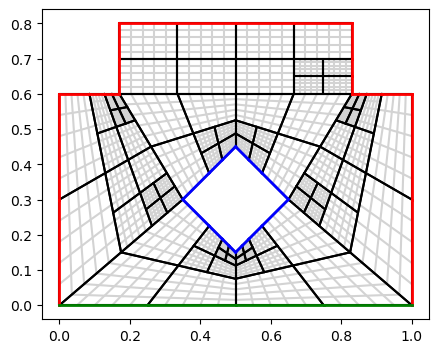

setting up constraints took 0.19679617881774902 seconds.
Basis setup took 0.004073143005371094 seconds
Residual contributions took 0.486 seconds.
Jump contributions took 0.827 seconds.


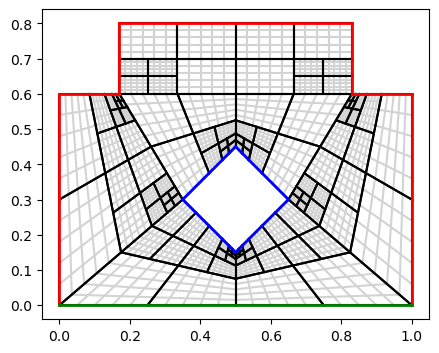

setting up constraints took 0.29183459281921387 seconds.
Basis setup took 0.004750728607177734 seconds
Residual contributions took 0.68 seconds.
Jump contributions took 1.21 seconds.


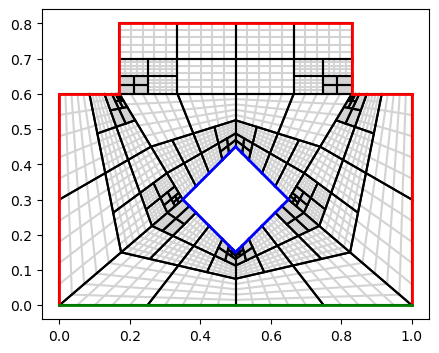

setting up constraints took 0.38242387771606445 seconds.
Basis setup took 0.005310773849487305 seconds
Residual contributions took 0.904 seconds.
Jump contributions took 1.61 seconds.


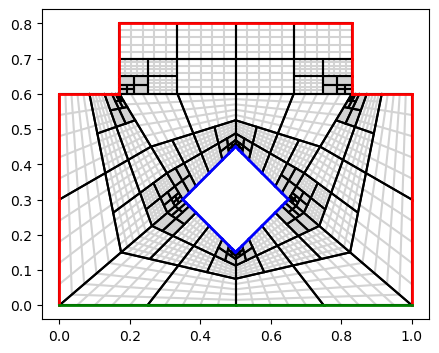

setting up constraints took 0.5075328350067139 seconds.
Basis setup took 0.0062253475189208984 seconds
Residual contributions took 1.14 seconds.
Jump contributions took 2.08 seconds.


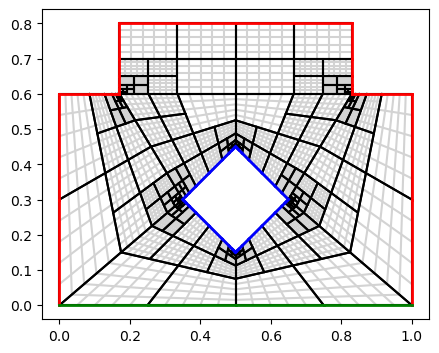

setting up constraints took 0.6297788619995117 seconds.
Basis setup took 0.007069110870361328 seconds
Residual contributions took 1.4 seconds.
Jump contributions took 2.53 seconds.


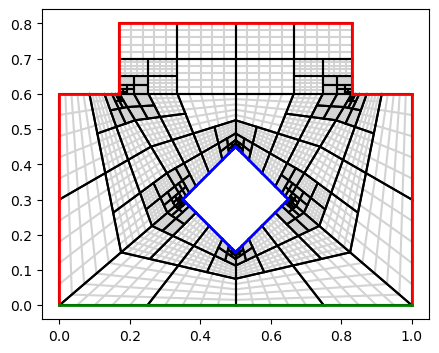

setting up constraints took 0.7355465888977051 seconds.
Basis setup took 0.007875680923461914 seconds
Residual contributions took 1.64 seconds.
Jump contributions took 3.07 seconds.


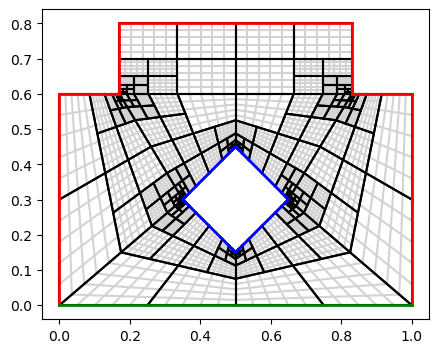

setting up constraints took 0.8772821426391602 seconds.
Basis setup took 0.008708477020263672 seconds
Residual contributions took 1.93 seconds.
Jump contributions took 3.52 seconds.


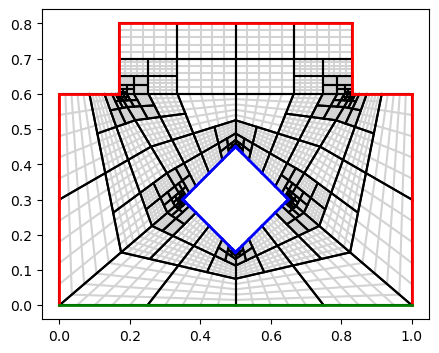

setting up constraints took 1.0019044876098633 seconds.
Basis setup took 0.009527921676635742 seconds
Residual contributions took 2.19 seconds.
Jump contributions took 4.03 seconds.


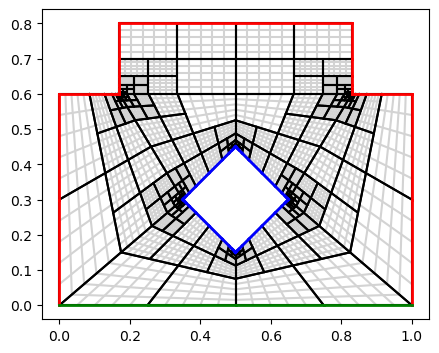

setting up constraints took 1.1395130157470703 seconds.
Basis setup took 0.010568618774414062 seconds
Residual contributions took 2.51 seconds.
Jump contributions took 4.65 seconds.


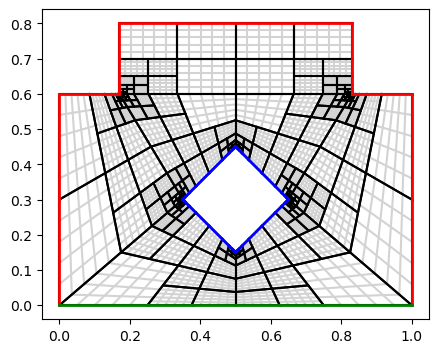

setting up constraints took 1.2954871654510498 seconds.
Basis setup took 0.01141810417175293 seconds
Residual contributions took 2.82 seconds.
Jump contributions took 5.23 seconds.


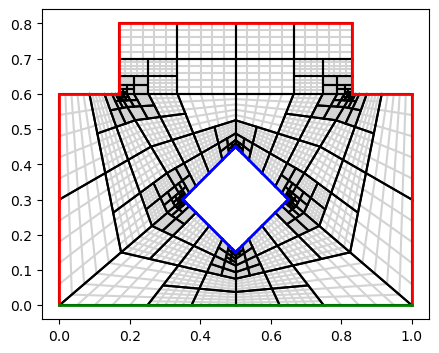

setting up constraints took 1.4462828636169434 seconds.
Basis setup took 0.012543439865112305 seconds
Residual contributions took 3.18 seconds.
Jump contributions took 5.82 seconds.


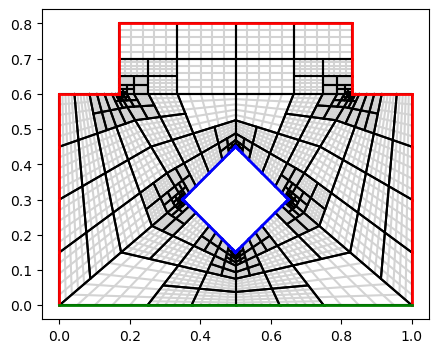

setting up constraints took 1.62284255027771 seconds.
Basis setup took 0.01365208625793457 seconds
Residual contributions took 3.69 seconds.
Jump contributions took 6.76 seconds.


In [24]:
M = ComputerChip(3,5)

maxiter=15
for it in range(maxiter):
    M.plotmesh(figsize=(5,5),patch_idx = False, knots=True, nodes=False, bcolor={'Dirichlet':'blue','Neumann':'red','Robin':'green'}, bwidth=2)
    plt.axis('scaled');
    plt.show()

    MP = assemble.Multipatch(M, automatch=True)
    dir_bcs = MP.set_dirichlet_boundary({'Dirichlet':gD})

    #assemble and solve
    u = solveChip(MP)

    #estimate
    err_ind = adaptive.mp_resPois(MP,u,a={0:lambda0, 1:lambda1}, f={0:f, 1:f})

    #mark
    marked_patches = adaptive.quick_mark(err_ind, theta=0.95)

    #refine
    if it != maxiter-1:
        M.h_refine(patches=marked_patches,ref="rs");